# 2. Approximate Retrieval

Quickly find nearest neighbors in (very) high dimensions.

Examples:
 * Image search and image completion
 * Song search

## Distance functions

 * $d : S \times S \rightarrow \mathbb{R}$ is a **distance function** iff
     - $\forall s, t \in S : d(s, t) \ge 0$
     - $\forall s : d(s, s) = 0$
     - $\forall s, t \in S : d(s, t) = d(t, s)$
     - $\forall s, t, r \in S: d(s, t) + d(t, r) \ge d(s, r)$ (triangle inequality)
     - if $\forall s, t \in S: d(s, t) = 0 \implies s = t$, then d is a "stronger" function called a **metric**
 * We make use of this by representing **objects as vectors**
     - images become feature vectors (see Computer Vision course)
     - documents become bag-of-words or tf-idf representations
 * Many types of distances
     - $\ell_p$, such as the Euclidean distance ($\ell_2$)
     - cosine distance (used a lot in text search)
     - edit distance (expensive)
     - Jaccard-distance (for sets)

## Curse of dimensionality
In very large dimensions, the minimum distance between any two points gets very close to the maximum distance between any points.

$ \lim_{D \rightarrow \infty} P[d_{max} \le (1 + \epsilon)d_{min}] = 1 $

## Approximate retrieval
### Input
A data set $S$ and a distance function $d$.

### Problem 1: Nearest neighbor
Given $q$, find $s* = \text{argmin}_{s \in S} d(q, s)$

### Problem 2: Near-duplicate detection
Find all $s$, $s'$ in $S$, with distance at most $\epsilon$.

* Use **shingling** and **Jaccard distance** as a similarity measure.
* Can even hash shingles to save space
* Jaccard similarity: $JSim(A, B) = \frac{|A \cap B|}{|A \cup B|}$
* Jaccard distance: $d(A, B) = 1 - JSim(A, B)$

In [2]:
def jaccard_sim(a, b):
    return len(a & b) * 1.0 / len(a | b)

def jaccard_distance(a, b):
    return 1 - jaccard_sim(a, b)

x = {1, 5, 6, 10}
y = {2, 5, 6, 20}
print("Similarity: %.2f" % jaccard_sim(x, y))
print("Distance:   %.2f" % jaccard_distance(x, y))

Similarity: 0.33
Distance:   0.67


* Scale remains problematic; we can't just do a double loop over all $N$ elements...
* Hashing works well for exact duplicates, can it work with near duplicates?
* **Yes**, we have **locality sensitive hashing** (LSH)

## Min-hashing
 * Reorder shingle matrix rows with random permutation $\pi$
 * $\operatorname{hash}(C) =$ minimum row number in which permuted column contains a one (C represents a column, i.e. a document in shingle form)
 * $h(C) = h_\pi(C) = \underset{i:C(i)=1}{\min}\pi(i)$ (hence the **min** in min-hashing)
 * Turns out that the probability of two documents sharing a hash is equal to their Jaccard similarity: $P[h(C_1) = h(C_2)] = Sim(C_1, C_2)$ (trivial but interesting proof; see slides)
 * This means we can use many hash functions, see how often they clash for a pair of documents, and we have a decent estimate for the documents' similarity
 * An alternative to min-hashing is sim-hashing (see Information Retrieval)

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [45]:
shingle_matrix = np.array([
    [1, 0, 1, 0],
    [1, 0, 0, 1],
    [0, 1, 0, 1],
    [0, 1, 0, 1],
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [1, 0, 1, 0]
])

* Want to find all duplicates with > 90% similarity
* Apply min-hash to all documents and look for candidate pairs (documents hashed to same bucket)
    - we find 90% of 90%-duplicates (since the probability of a single hash function colliding is 90% by design)
    - we miss 10% of 90%-duplicates
    - $P(\text{miss with 1 function }) = 1 - s$ ($s$ = similarity)
    - $P(\text{miss with k functions}) = (1 - s)^k$
    - multiple hash functions $\implies$ exponentially fewer misses!

In [46]:
def min_hash(matrix, permutation):
    signature = [None for col in matrix[0]]
    for index, row in enumerate(permutation):
        for col, byte in enumerate(signature):
            if byte is None and matrix[row][col] == 1:
                signature[col] = index
                    
    return signature


def array_sim(a1, a2):
    in_common = len(a1[a1 == a2])
    total = len(a1)
#     print("In common: %d" % in_common)
#     print("Total:     %d" % total)
    return in_common * 1.0 / total


def col_col_sim(matrix, c1_index, c2_index):
    tr = matrix.T
    c1 = tr[c1_index]
    c2 = tr[c2_index]
    return array_sim(c1, c2)

    
def sig_sig_sim(matrix, c1_index, c2_index, hash_fns):
    sig_matrix = np.array([min_hash(matrix, hf) for hf in hash_fns])
    tr = sig_matrix.T
    c1 = tr[c1_index]
    c2 = tr[c2_index]
    return array_sim(c1, c2)
        
    

In [47]:
# Same permutations as in slides, just 0-indexed and reversed
p1 = [0, 4, 1, 6, 5, 3, 2]
p2 = [2, 1, 3, 0, 6, 4, 5]
p3 = [4, 5, 0, 1, 6, 3, 2]
print(min_hash(shingle_matrix, p1))
print(min_hash(shingle_matrix, p2))
print(min_hash(shingle_matrix, p3))

[0, 1, 0, 1]
[1, 0, 3, 0]
[1, 0, 1, 0]


In [48]:
hash_fns = [p1, p2, p3]
pairs = [(0, 2), (1, 3), (0, 1), (2, 3)]
for c1, c2 in pairs:
    print("Columns %d and %d:" % (c1 + 1, c2 + 1))
    print("Col/col similarity: %.2f" % col_col_sim(shingle_matrix, c1, c2))
    print("Sig/sig similarity: %.2f" % sig_sig_sim(shingle_matrix, c1, c2, hash_fns))

Columns 1 and 3:
Col/col similarity: 0.86
Sig/sig similarity: 0.67
Columns 2 and 4:
Col/col similarity: 0.86
Sig/sig similarity: 1.00
Columns 1 and 2:
Col/col similarity: 0.00
Sig/sig similarity: 0.00
Columns 3 and 4:
Col/col similarity: 0.00
Sig/sig similarity: 0.00


## Scaling up min-hash
 * While the above method works well, it's quite problematic to actually permute a huge dataset
 * We therefore want to implement the permutations as linear hash funtions (see your local linear algebra course for more info about why this works!)
 * Use $\pi(r) = a \cdot r + b \operatorname{mod} n =: h_{a,b}(r)$
 * This is huge! It allows us to iteratively process any shingle matrix (row-wise), without having to actually move (huge) data around (necessary for performing actual permutations).
 * $h_{a,b}$ is efficient to store

## Increasing the accuracy
 * More hash functions, any collision $\implies$ similar leads to **fewer false negatives**, but **more false positives**

In [56]:
index = np.arange(0, 1, 0.01)
curves = {'k = %d' % k: 1 - (1 - index) ** k for k in range(1, 20, 2)}
fr = pd.DataFrame(data=curves, index=pd.Index(index))

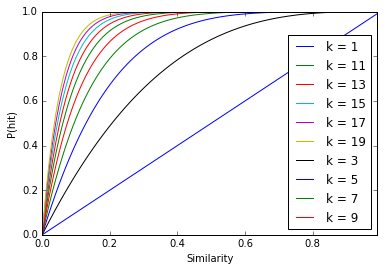

In [57]:
ax = fr.plot()
plt.xlabel("Similarity")
plt.ylabel("P(hit)")

 * At this point, we would still need to do pairwise comparison of columns in the signature matrix and see whether they are close enough. Even though we would typically use far fewer hash functions than we would have shingles, we're still talking about $\mathcal{O}(N^2)$ operations.
 * Let's hash some more!
 * Hash entire columns (i.e. sets of many min-hashes of the same document) and bucketize; only evaluate similarity of the documents which share a bucket.
 * Split matrix **rows into $b$ bands** of $r$ rows. So each band contains a few ($r$) hashes for **all** documents.
 * We do a bucketization in each band.
 * (Just use a linear hash function to hash the partial signature for every band, for every document.)
 * $h_{a_i, b}(s) = \sum\limits_{i=1}^{r}a_is_i + b \operatorname{mod} n$, with $a_1, \dots, a_r$ and $b$ random
 * Each band is independent (i.e. its own hash table)
 * If there's a collision between two documents in at least one band, treat the documents as candidates. Why is this useful?

## Open questions
* Why perform first step of hashing if we only have a small number of features (e.g. 100)? If many features, why not just do a PCA first?